In [1]:
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SQLContext
# MF libraries
from pyspark.mllib.recommendation import ALS, \
                        MatrixFactorizationModel, Rating
import matplotlib.pyplot as plt

**Exploratory Data Analysis
Neighborhood-based (item-based CF)
1) Remove items that have 0 ratings (unrated) ~500 movies
2) Remove most popular movies ~?
3) Our definition of popular: Movies with many ratings (Need to define “many” based on the dataset) e.g. top 10% of most rated items 
4) Then, random sampling for our small dataset (10% remaining data)



## Data and Methods (Sampling)
1) Original data contains 138493 users and 26744 items (Approximately 20M ratings).

   Original data only contains users that rated more than 20 items. 
2) In order to develop our Item-based CF model with a small data set (Approx. <10,000 users / <1,000 items), we sampled the data based on the following rationale and steps:
    i) Remove ubiquitous items (e.g. top 0.5% most rated items across users) as well as items that have extremely few ratings (e.g. items rated only once). Recommending items that have been rated by majority of users are likely to be redundant and have less value in terms of novelty of the recommendation. Since we aim to provide item recommendations that the user might not have experienced yet, it seemed reasonable to remove top 0.5% of items that have been rated by many users. Regarding items that have extremely few ratings, these items would not contribute much in terms of item similarity, so we have decided to remove those user-item pairs with single ratings as well. 

Our goal is to provide movie recommendations based on items that...
- ubiquitous: likely that most/many users would have already watched l                                              
- few rating? : lack accuracy
-middle ground 

3) Then, we sampled a small dataset


(Recommendations cannot be made for cold start users/items)
Common sampling approaches:
- build the algorithm using only users/items with a minimum n interactions
- leave out m items from each user row, or leave out n users from each user row


In [2]:
df = pd.read_csv('ratings.csv')

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
userNum = len(df.userId.unique()) #138493 users
itemNum = len(df.movieId.unique()) #26744 items

print(userNum, itemNum)

138493 26744


In [5]:
df_item_summary = pd.DataFrame(df.groupby('movieId').size(), columns=['count'])

In [6]:
df_item_summary.max()
df_item_summary.min()
df_item_summary.describe()

,count
count,26744.000000
mean,747.841123
std,3085.818268
min,1.000000
25%,3.000000
50%,18.000000
75%,205.000000
max,67310.000000


In [7]:
df_item_summary.sum()

count    20000263
dtype: int64

In [8]:
df_item_summary = df_item_summary.sort_values(by='count', ascending=False) 
a = df_item_summary.nlargest(int(len(df_item_summary)*0.005), 'count') 
a.sum()/df_item_summary.sum()

count    0.217018
dtype: float64

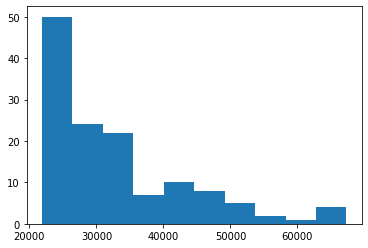

In [9]:
plt.hist(a['count'])
plt.show()

In [10]:
top_05 = list(a.index.values) #133 items 
one_item_idx = df_item_summary[df_item_summary['count']==1].index.tolist() #3972
remove_list = top_05 + one_item_idx #4105 items
print(len(remove_list)) 
new_df = df[~df.movieId.isin(top_05)]
new_df.head()

4105


,userId,movieId,rating,timestamp
1,1,29,3.5,1112484676
5,1,112,3.5,1094785740
6,1,151,4.0,1094785734
13,1,337,3.5,1094785709
18,1,653,3.0,1094785691


In [12]:
new_user = len(new_df.userId.unique())
new_item = len(new_df.movieId.unique())
print(new_user, new_item)
new_df.describe()
#137542 22639

137542 26611


,userId,movieId,rating,timestamp
count,1.565985e+07,1.565985e+07,1.565985e+07,1.565985e+07
mean,6.901693e+04,1.117394e+04,3.445954e+00,1.110063e+09
std,4.004482e+04,2.187546e+04,1.057272e+00,1.585046e+08
min,1.000000e+00,3.000000e+00,5.000000e-01,7.896520e+08
25%,3.436200e+04,1.256000e+03,3.000000e+00,9.749575e+08
50%,6.908200e+04,2.712000e+03,3.500000e+00,1.108593e+09
75%,1.036000e+05,5.773000e+03,4.000000e+00,1.231299e+09
max,1.384930e+05,1.312620e+05,5.000000e+00,1.427784e+09


In [14]:
sample =new_df.sample(frac=0.0001, random_state=1)

In [15]:
user = len(sample.userId.unique())
item = len(sample.movieId.unique())
print(user, item)

1523 1154


In [16]:
sample.head()
M = pd.pivot_table(sample, values='rating', index='movieId', columns='userId')
M.head()

userId,56,192,370,408,431,471,687,758,786,801,...,137170,137237,137429,137478,137641,137653,137675,137974,137996,138006
movieId,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

def item_similarity(M,k):
    M[np.isnan(M)] = 0 #fill empty cells with 0 (M = M.fillna(0)#)
    cosine = cosine_similarity(M)
    np.fill_diagonal(cosine, 0)
    sim_matrix = pd.DataFrame(cosine, index=M.index)
    sim_matrix.columns=M.index
    
    order = np.argsort(sim_matrix.values, axis=1)[:, :k]
    sim_matrix = sim_matrix.apply(lambda x: pd.Series(x.sort_values(ascending=False)
        .iloc[:k].index,
    index = ['top{}'.format(i) for i in range(1, k+1)]), axis=1)
    
    return sim_matrix

#item_similarity(M)
    

In [18]:
#M = M.transpose()
M[np.isnan(M)] = 0
cosine = cosine_similarity(M)
np.fill_diagonal(cosine,0)
#print(M.index)
sim_matrix = pd.DataFrame(cosine, index=M.index)
sim_matrix.columns=M.index
sim_matrix


#find n neighbors
order = np.argsort(sim_matrix.values, axis=1)[:, :5]
sim_matrix = sim_matrix.apply(lambda x: pd.Series(x.sort_values(ascending=False)
    .iloc[:5].index,
    index = ['top{}'.format(i) for i in range(1, 5+1)]), axis=1)

sim_matrix

,top1,top2,top3,top4,top5
movieId,,,,,
3,113862,1299,1876,1883,1884
4,113862,1299,1876,1883,1884
7,113862,1299,1876,1883,1884
11,113862,1299,1876,1883,1884
14,113862,1299,1876,1883,1884
17,113862,1299,1876,1883,1884
19,113862,1299,1876,1883,1884
22,113862,1299,1876,1883,1884
24,113862,1299,1876,1883,1884


In [19]:
# TESTING SURPRISE PACKAGE 
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

from surprise.model_selection import KFold


from surprise import Reader

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(new_df[['userId', 'movieId', 'rating']], reader)


# Load the dataset
#data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.15)

# item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)

# run the trained model against the testset
test_pred = algo.test(testset)

# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

print("Item-based Model : Training Set")
train_pred = algo.test(trainset.build_testset()) #evaluate trainset
accuracy.rmse(train_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Item-based Model : Test Set
RMSE: 1.0831
Item-based Model : Training Set
RMSE: 0.0782


0.07824764457131182

## cross-validation to find k (three-fold?)
#then use that k to 



In [23]:
data = Dataset.load_from_df(new_df[['userId', 'movieId', 'rating']], reader)

In [ ]:
from surprise.model_selection import KFold
kf = KFold(n_splits=3)

possibleK = [3,5,10,25,50]

for k in possibleK:
    print('parameter', k)
    
    algo = KNNWithMeans(k=k, sim_options={'name': 'cosine', 'user_based': False})
    for trainset, testset in kf.split(data):
        
        #algo = KNNWithMeans(k=k, sim_options={'name': 'cosine', 'user_based': False})

        algo.fit(trainset)
        predictions = algo.test(testset)

        accuracy.rmse(predictions, verbose=True)
        accuracy.fcp(predictions, verbose=True)

parameter 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9412
FCP:  0.6558
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9399
FCP:  0.6562
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9410
FCP:  0.6557
parameter 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8987
FCP:  0.6717
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8981
FCP:  0.6728
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8982
FCP:  0.6725
parameter 10
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8670
FCP:  0.6898
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8666
FCP:  0.6896
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8664
FCP:  0.6894
parameter 25
Computing the cosine similarity 

## COVERAGE

In [ ]:
data = []
for i in range(len(test_pred)):
    data.append([test_pred[i][0],test_pred[i][1],test_pred[i][2],test_pred[i][3]])

df1 = pd.DataFrame(data, columns = cols).sort_values(by=['user', 'est'])
ratings_dictionary = dict(df1.set_index('user').groupby(level = 0).apply(lambda x : x.to_dict(orient= 'records')))


def coverage(ratingsDict, k, testset):
    
    totalMovies = []
    for i in (testset):
        totalMovies.append(i[1])
    totalMovies = list(dict.fromkeys(totalMovies))

    recList = []
    for keys in ratingsDict.keys():
        
        if k >= len(ratingsDict[keys]):
            for i in ratingsDict[keys]:
                recList.append(i['item'])
        else:
            for index, item in enumerate(sorted(ratings_dictionary[keys], key=lambda x: -x['est'])):
                if index+1 <= k:
                    recList.append(item['item'])
                else:
                    pass
    recList = list(dict.fromkeys(recList))
    
    print(len(recList)/len(totalMovies))

coverage(ratings_dictionary, 1, testset)

## NDCG

In [ ]:
def dcg_score(y_true, y_score, k=10, gains="exponential"):
    """Discounted cumulative gain (DCG) at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    gains : str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    -------
    DCG @k : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    """Normalized discounted cumulative gain (NDCG) at rank k
    Parameters
    —————
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    gains : str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    ———
    NDCG @k : float
    """
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual / best

In [ ]:
ndcg_score(df1['r_ui'].values.tolist(), df1['est'])